# Preliminary Naive Bayes Model for Sentiment Polarity

Import necessary dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# For Tokenizing
import re
import string
import itertools
from spellchecker import SpellChecker
from contractions import contractions_dict

from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

# For Text Classification
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from nltk.corpus import subjectivity
from nltk.classify import NaiveBayesClassifier

Download Necessary Corpus for tokenizer, and sentiment analyzers to work.

In [2]:
download('punkt')
download('stopwords')
download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/lyqht/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lyqht/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lyqht/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## The Dataset

Import the dataset and rename some columns

In [3]:
df = pd.read_csv("../data/googleplaystore_user_reviews.csv")
df.rename(columns = {'Translated_Review':'Review'}, inplace=True)
df.sample(4)

,App,Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
13162,Battlelands Royale,"This game excellent mechanics, little bugs, ni...",Positive,0.327500,0.755000
271,11st,Open Market Revolution A section of the Helo-S...,Positive,0.166667,0.500000
40425,Episode - Choose Your Story,"love game, I dont get anymore free passes.",Positive,0.166667,0.600000
14950,BioLife Plasma Services,"This supposed easy right?? In land ""smart"" tec...",Positive,0.245000,0.542024


## Terminology
Source of definitions: Bing Liu. Sentiment Analysis and Opinion Mining, Morgan & Claypool Publishers, May 2012
- Sentiment Polarity: Can be split into rational or emotional sentiment. Hence resulting in the common design of 5 sentiment ratings.
    - emotional negative (-2)
    - rational negative (-1)
    - neutral (0): In practice, neutral often means no opinion or sentiment expressed.
    - rational positive (+1)
    - emotional positive (+2)
- Sentiment Subjectivity: Subjective sentences expresses some personal feelings, views, or beliefs. They may not express any sentiment. 




We see that the original dataset also has labels of the sentiment level, polarity and subjectivity by the original author. 
We will build our own model then compare the values to the values in the original dataset for comparison.

Getting the reviews 

In [4]:
raw_reviews = df["Review"].copy()
raw_reviews.sample(5)

36843                                                  NaN
31631    I can't believe amazing add stuff it'll great ...
61265                                                  NaN
60015                                                 Nice
13672                                                  NaN
Name: Review, dtype: object

# Text Mining

## Preprocessing

We will drop NA types in the reviews data, since they do not contain any text. They probably got into the dataset because of imperfect data scraping.

In [5]:
reviews = raw_reviews.dropna(axis=0)
print("Old data frame length:", len(raw_reviews), "\nNew data frame length:",  
       len(reviews), "\nNumber of rows with at least 1 NA value: ", 
       (len(raw_reviews)-len(reviews))) 

Old data frame length: 64295 
New data frame length: 37427 
Number of rows with at least 1 NA value:  26868


These are the preprocessing steps that we will be doing for every review.
1. Converting text to lowercase
2. Remove html tags
3. Expand Contractions
    - Dictionary source from : https://github.com/pemagrg1/Text-Pre-Processing-in-Python/blob/master/individual_python_files/contractions.py
4. Remove punctuation
5. Using NLKT's `PunktSentenceTokenizer` to create tokens
6. Word Normalization for Tokens
    - Correcting mispelled words
    - Stop word removal
    - Lemmatization 

In [6]:
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))
spell = SpellChecker()

In [7]:
# Regex Patterns
html_pattern = re.compile('<[^<]+?>')
lengthening_pattern = re.compile(r"(.)\1{2,}")
contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

In [8]:
def remove_html_tags(s):
    global html_pattern
    return html_pattern.sub('', s)
    
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))    

def expand_contractions(text):
    global contractions_pattern
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def reduce_lengthening(s):
    global lengthening_pattern
    return lengthening_pattern.sub(r"\1\1", s)

def lemmatize(w):
    global lemmatizer
    return lemmatizer.lemmatize(w)

def normalize(s):
    global spell
    tokens = word_tokenize(s)
    tokens = [lemmatize(word) for word in tokens]
    return tokens

def preprocess(s):
    s = s.lower()
    s = remove_html_tags(s)
    s = expand_contractions(s)
    s = remove_punctuation(s)
    s = reduce_lengthening(s)
    words = normalize(s)
    
    return words

Testing preprocessing on some reviews

In [9]:
random_sample = reviews.sample(5)
print("Random Sample")
print(random_sample, "\n")
print("Normalized Tokens produced")
random_sample.progress_apply(preprocess)

  0%|          | 0/5 [00:00<?, ?it/s]

Random Sample
37456    This game amazing simple problem! TOO MANY ADS...
39374                                Nothing new kids love
7307                                Keep make game better.
55713    The simplicity beautiful. It easy use. The wor...
19128    It works got ad problems turn WiFi/3G face pro...
Name: Review, dtype: object 

Normalized Tokens produced


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


37456    [this, game, amazing, simple, problem, too, ma...
39374                            [nothing, new, kid, love]
7307                            [keep, make, game, better]
55713    [the, simplicity, beautiful, it, easy, use, th...
19128    [it, work, got, ad, problem, turn, wifi3g, fac...
Name: Review, dtype: object

Applying preprocessing to all the reviews

In [10]:
tokens = reviews.apply(preprocess)
processed_df = pd.DataFrame(reviews)
processed_df["Tokens"] = tokens
processed_df.sample(5)

,Review,Tokens
5863,Funny thing happened,"[funny, thing, happened]"
28928,"Times fast. It's ok, near great","[time, fast, it, is, ok, near, great]"
21369,Just put phone.,"[just, put, phone]"
63201,"I love easy use, great locating properties are...","[i, love, easy, use, great, locating, property..."
30960,I would rate 5 stars seasons big series like F...,"[i, would, rate, 5, star, season, big, series,..."


Saving this data for reuse

In [11]:
processed_df.to_csv("../data/tokenized.csv")

Visualizing the most common tokens and saving the plot

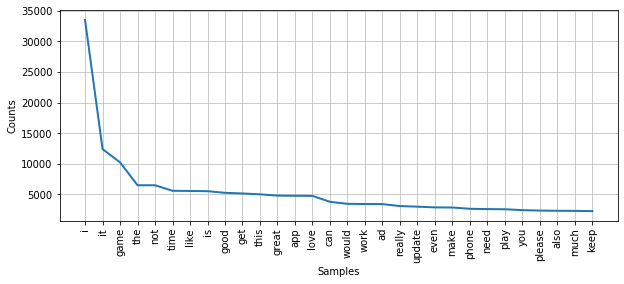

In [11]:
fig = plt.figure(figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15)

word_counts = list(itertools.chain(*tokens))
freq_dist = FreqDist(word_counts)
freq_dist.plot(30, cumulative=False)

plt.show()
fig.savefig('images/freqDist.png', bbox_inches = "tight")

Some steps that we did not include for preprocessing that could affect our model:
- Removing numbers: sometimes in reviews we see that users explain their rationale of giving a specific number of star rating, so we did not want to remove them.
- Removing chinese reviews and apps: We assumed that China does not have access to Google Playstore, so there will be lesser chinese reviews and apps made in Chinese, but this is certainly not true. However, filtering them out is a hassle atm so we did not do this step.
- Spell Checking every token: We tried this, but it causes the computation to be taking too long! So we ignore it for now...

# Modelling

We will use `VADER SentimentIntensityAnalyzer` for calculating polarity scores for each review. The scoring is computed as following from https://github.com/cjhutto/vaderSentiment:

- The `compound` score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
    - positive sentiment: compound score >= 0.05
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - negative sentiment: compound score <= -0.05

The `pos`, `neu`, and `neg` scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [12]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_polarity(s):
    global analyzer
    polarity_scores = analyzer.polarity_scores(s)
    compound_score = polarity_scores["compound"]
    if compound_score >= 0.5:
        label = "Positive"
    elif compound_score > -0.05 and compound_score < 0.05:
        label = "Neutral"
    else:
        label = "Negative"
    return label, polarity_scores["neu"], polarity_scores["pos"], polarity_scores["neg"]

In [13]:
df = processed_df
df["Sentiment"], df["Neutral Proportion"], df["Positive Proportion"], df["Negative Proportion"] =  zip(*df["Review"].apply(sentiment_polarity))
df.sample(3)

,Review,Tokens,Sentiment,Neutral Proportion,Positive Proportion,Negative Proportion
37236,Best,[best],Positive,0.000,1.000,0.00
35953,It nice first days began demanding I upgrade I...,"[it, nice, first, day, began, demanding, i, up...",Negative,0.594,0.176,0.23
45118,This exactly I've looking for! Did preview wat...,"[this, exactly, looking, for, did, preview, wa...",Positive,0.706,0.294,0.00


In [14]:
df.to_csv("../data/polarity.csv")

Now we will classify the reviews based on subjectivity using a `NaiveBayesClassifier`. First, we split the data for testing and training.

In [15]:
test_size = int(0.2*len(reviews))
x_train = df[:test_size]
x_test = df[test_size:]

Next, we build a vocabulary consisting of all the words that the training set of reviews have. From the output, you can see that there is still much to be improved upon for the tokens that were obtained despite the preprocessing.

In [16]:
vocabulary = set(word_counts)
print("Number of words in vocabulary: {}".format(len(vocabulary)))
vocabulary

Number of words in vocabulary: 22322


{'mae',
 'sure',
 'acknowledges',
 'fastand',
 'fulfilling',
 'require',
 'obama',
 'stoptheadabuse',
 'kia',
 'confidence',
 'sinc',
 'wordlists',
 'lainnya',
 'newborn',
 'appreciable',
 'followed',
 '15mbps',
 'wayright',
 'mohochar',
 'engrained',
 'pic',
 'crosscountry',
 'nolonger',
 'victory',
 'refreshment',
 'strapped',
 'destroying',
 'valavala',
 'payforeverything',
 'drove',
 'poor',
 'simulate',
 '2917',
 'believe',
 'begginer',
 'press',
 'sensationalized',
 'shade',
 'acoutered',
 'wasnt',
 'syntax',
 'her',
 's7',
 'stocked',
 'playersyou',
 'filtersall',
 'unlimited',
 'mydiary',
 'awarding',
 'unwantedly',
 'autofilling',
 'nigeria',
 'browsing',
 'print',
 'internation',
 'noisy',
 'abroad',
 'meaning',
 'roller',
 'opposite',
 'lazers',
 'ghana',
 'discusting',
 'crono',
 'h2o',
 'number6157202',
 'fightingharvesting',
 'routine',
 'upbadges',
 'calorie',
 'penalize',
 'clubcard',
 'hahaha',
 'wiki',
 'technology',
 'haha',
 '22k',
 'disney',
 '73018',
 'fategrand',

Then for each data point (tokens with the pos/neg tag), we will build a dictionary that says whether it has particular features/ words from the vocabulary.

In [17]:
def features_with_labels(row):
    return ({i:(i in row["Review"]) for i in vocabulary}, row["Sentiment"])

features = x_train.progress_apply(features_with_labels, axis=1)

100%|██████████| 7485/7485 [15:23<00:00,  8.11it/s]


In [18]:
classifier = NaiveBayesClassifier.train(features)

In [19]:
classifier.show_most_informative_features()

Most Informative Features
                   great = True           Positi : Neutra =     51.5 : 1.0
                    easy = True           Positi : Neutra =     48.2 : 1.0
                     lov = True           Positi : Neutra =     33.8 : 1.0
                    love = True           Positi : Neutra =     33.1 : 1.0
                horrible = True           Negati : Positi =     26.9 : 1.0
                    nice = True           Positi : Neutra =     26.5 : 1.0
                provider = True           Neutra : Positi =     25.8 : 1.0
                   relax = True           Positi : Negati =     21.2 : 1.0
                     hop = True           Positi : Neutra =     21.1 : 1.0
                     lem = True           Negati : Neutra =     20.0 : 1.0


In [ ]:
def features(row):
    return {i:(i in row["Review"]) for i in vocabulary}

test_features = x_test.progress_apply(features,axis=1)